<a href="https://colab.research.google.com/github/rakaboss98/OptiSAR-CycleGAN/blob/main/SimpleGans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 82 kB 753 kB/s 
     |████████████████████████████████| 15.7 MB 21.3 MB/s 
     |████████████████████████████████| 9.9 MB 58.8 MB/s 
     |████████████████████████████████| 11.2 MB 42.2 MB/s 
     |████████████████████████████████| 61 kB 9.5 MB/s 
     |████████████████████████████████| 944 kB 60.5 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    

In [1]:
import torch
from torch import nn
from d2l import torch as d2l 
import matplotlib.pyplot as plt

In [2]:
# Generating gaussian shifted data with mean b and covariance A'A
X = torch.normal(0,1,(1000,2))
A = torch.tensor([[1,2],[-0.1,0.5]])
b = torch.tensor([1,2])
data = torch.matmul(X,A)+b

The covariance matrix is
tensor([[1.0100, 1.9500],
        [1.9500, 4.2500]])


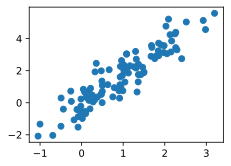

In [3]:
d2l.set_figsize()
d2l.plt.scatter(data[:100, (0)].detach().numpy(), data[:100, (1)].detach().numpy());
print(f'The covariance matrix is\n{torch.matmul(A.T, A)}')

In [4]:
# Creating Data Loaders
batch_size = 8 
data_iter = d2l.load_array((data,), batch_size)

In [5]:
# Creating Generator and discriminator models
net_G = nn.Sequential(nn.Linear(in_features=2,out_features=2))
net_D = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Tanh(),
    nn.Linear(in_features=5, out_features=3),
    nn.Tanh(),
    nn.Linear(in_features=3, out_features=1)
)
print(net_G)
print(net_D)

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
)
Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Tanh()
  (2): Linear(in_features=5, out_features=3, bias=True)
  (3): Tanh()
  (4): Linear(in_features=3, out_features=1, bias=True)
)


In [6]:
# Updating the discriminator
def update_D(X, Z, net_G, net_D, loss, trainer_D):
  batch_size = X.shape[0]
  ones = torch.ones((batch_size), device=X.device)
  zeros = torch.zeros((batch_size), device=X.device)
  trainer_D.zero_grad()
  real_Y = net_D(X)
  fake_X = net_G(Z)
  # Do not need to compute gradients from net_G so 
  # detach it from gradients
  fake_Y = net_D(fake_X.detach())
  loss_D = (loss(real_Y, ones.reshape(real_Y.shape))+loss(fake_Y, fake_Y.reshape))/2
  loss_D.backward()
  trainer_D.step()
  return loss_D


In [7]:
# Updating the generator
def update_G(Z, net_D, net_G, loss, trainer_G):
  batch_size = Z.shape[0]
  ones = torch.ones((batch_size), Z.device)
  trainer_G.zero_grad()
  # use fake_X from updated_D to save computation 
  fake_X = net_G(Z)
  # recomputing fake_Y is necessary since net_D has changes 
  fake_Y = net_D(fake_X)
  loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
  loss_G.backward()
  trainer_G.step()

In [8]:
# Training the GAN
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr_D)
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr_G)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(num_epochs):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for (X,) in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim))
            metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),
                       update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Visualize generated examples
        Z = torch.normal(0, 1, size=(100, latent_dim))
        fake_X = net_G(Z).detach().numpy()
        animator.axes[1].cla()
        animator.axes[1].scatter(data[:, 0], data[:, 1])
        animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
        animator.axes[1].legend(['real', 'generated'])
        # Show the losses
        loss_D, loss_G = metric[0]/metric[2], metric[1]/metric[2]
        animator.add(epoch + 1, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec')

RuntimeError: ignored

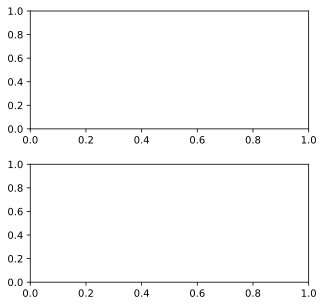

In [9]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G,
      latent_dim, data[:100].detach().numpy())
